# Data Science Research Methods Report-2

## **Introduction**<br>
The PAMAP2 Physical Activity Monitoring dataset (available here) contains data from 9 participants who participated in 18 various physical activities (such as walking, cycling, and soccer) while wearing three inertial measurement units (IMUs) and a heart rate monitor. This information is saved in separate text files for each subject. The goal is to build hardware and/or software that can determine the amount and type of physical activity performed by an individual by using insights derived from analysing the given dataset. 

In [1]:
import os
import pdb
from IPython.display import display
from matplotlib import rcParams
from scipy.stats import ranksums
import numpy as np
import seaborn as sns
os.chdir("/home/sahil/Downloads/PAMAP2_Dataset/Protocol")
import pandas as pd
import matplotlib.pyplot as plt

## Data Cleaning<br>
For tidying up the data :<br>
- We load the data of various subjects and give relevant column names<br>
  for various features. <br>
- The data for all subjects are then stacked together to form one table.<br>
- We remove the 'Orientation' columns because it was mentioned <br>
  in the data report that it is invalid in this data collection.<br>
- Similarly, the rows with Activity ID "0" are also removed as<br>
  it does not relate to any specific activity.<br>
- The missing values are filled up using the mean for that feature.


<br>
Given below are functions to give relevant names to the columns and create a<br>
single table containing data for all subjects<br>


In [2]:
def gen_activity_names():
    # Using this function all the activity names are mapped to their ids
    act_name = {}
    act_name[0] = 'transient'
    act_name[1] = 'lying'
    act_name[2] = 'sitting'
    act_name[3] = 'standing'
    act_name[4] = 'walking'
    act_name[5] = 'running'
    act_name[6] = 'cycling'
    act_name[7] = 'Nordic_walking'
    act_name[9] = 'watching_TV'
    act_name[10] = 'computer_work'
    act_name[11] = 'car driving'
    act_name[12] = 'ascending_stairs'
    act_name[13] = 'descending_stairs'
    act_name[16] = 'vacuum_cleaning'
    act_name[17] = 'ironing'
    act_name[18] = 'folding_laundry'
    act_name[19] = 'house_cleaning'
    act_name[20] = 'playing_soccer'
    act_name[24] = 'rope_jumping'
    return act_name
def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]
def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]
def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output
def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output

In [3]:
def load_subjects(root1='/home/sahil/Downloads/PAMAP2_Dataset/Protocol/subject',
        root2 ='/home/sahil/Downloads/PAMAP2_Dataset/Optional/subject' ):
    cols = load_IMU()
    output = pd.DataFrame()
    for i in range(101,110):
        path1 = root1 + str(i) + '.dat'
        path2 = root2 + str(i) + '.dat'
        subject= pd.DataFrame()
         
        subject_prot = pd.read_table(path1, header=None, sep='\s+') # subject data from 
         # protocol activities
        subject = subject.append(subject_prot)
        if(os.path.isfile(path2)): # checking if Optional data for that subject exists
           subject_opt = pd.read_table(path2, header=None, sep='\s+') # subject data from optional activities
           subject = subject.append(subject_opt)
        subject.columns = cols 
        subject = subject.sort_values(by='time_stamp') # Arranging all measurements according to
         # time
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    return output
data = load_subjects()# Add your own location for the data here to replicate the code
# for eg data = load_subjects('filepath')
data = data.drop(data[data['activity_id']==0].index)# Removing rows with activity id of 0
act = gen_activity_names()
data['activity_name'] = data.activity_id.apply(lambda x:act[x])
data = data.drop([i for i in data.columns if 'orientation' in i],axis=1)# Dropping Orientation 
# columns
display(data.head())

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,...,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,id,activity_name
5691,37.66,1,NaN,30.375,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,...,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,101,lying
5693,37.67,1,NaN,30.375,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,...,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,101,lying
5695,37.68,1,NaN,30.375,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,...,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,101,lying
5697,37.69,1,NaN,30.375,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,...,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,101,lying
5699,37.70,1,100.0,30.375,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,...,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,101,lying


**Note**: The procedure to replace missing values using the feature mean is performed<br>
after hypothesis testing and EDA as filling up the missing values would lead to us getting<br>
incorrect sample sizes for hypotheses testing. For Hypotheses testing the blank rows of an <br>
attribute will simply be ignored.

In [4]:
def clean_data(data): # Function for extracting clean data
    #data = data.interpolate()
    # fill all the NaN values in a column with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    return data

## Exploratory Data Analysis<br>
After labelling the data appropriately, it is randomly split into training and testing sets. <br>
In the training set, we perform Exploratory Data Analysis and come up with potential hypotheses. <br>
We then test those hypotheses on the testing set.<br>
50% of data is used for training in this case(Exploratory data analysis) and the rest for testing

In [5]:
def train_test_split(data,split_size):
    np.random.seed(5)
    msk = np.random.rand(len(data)) < split_size # This code implies 80% of the values will be True
    train = data[msk] # Generating training data
    test = data[~msk] # generating testing data  
    return train,test
train,test = train_test_split(data,0.50)

### Data Visualizations

* Boxplot of heart rate grouped by activity 

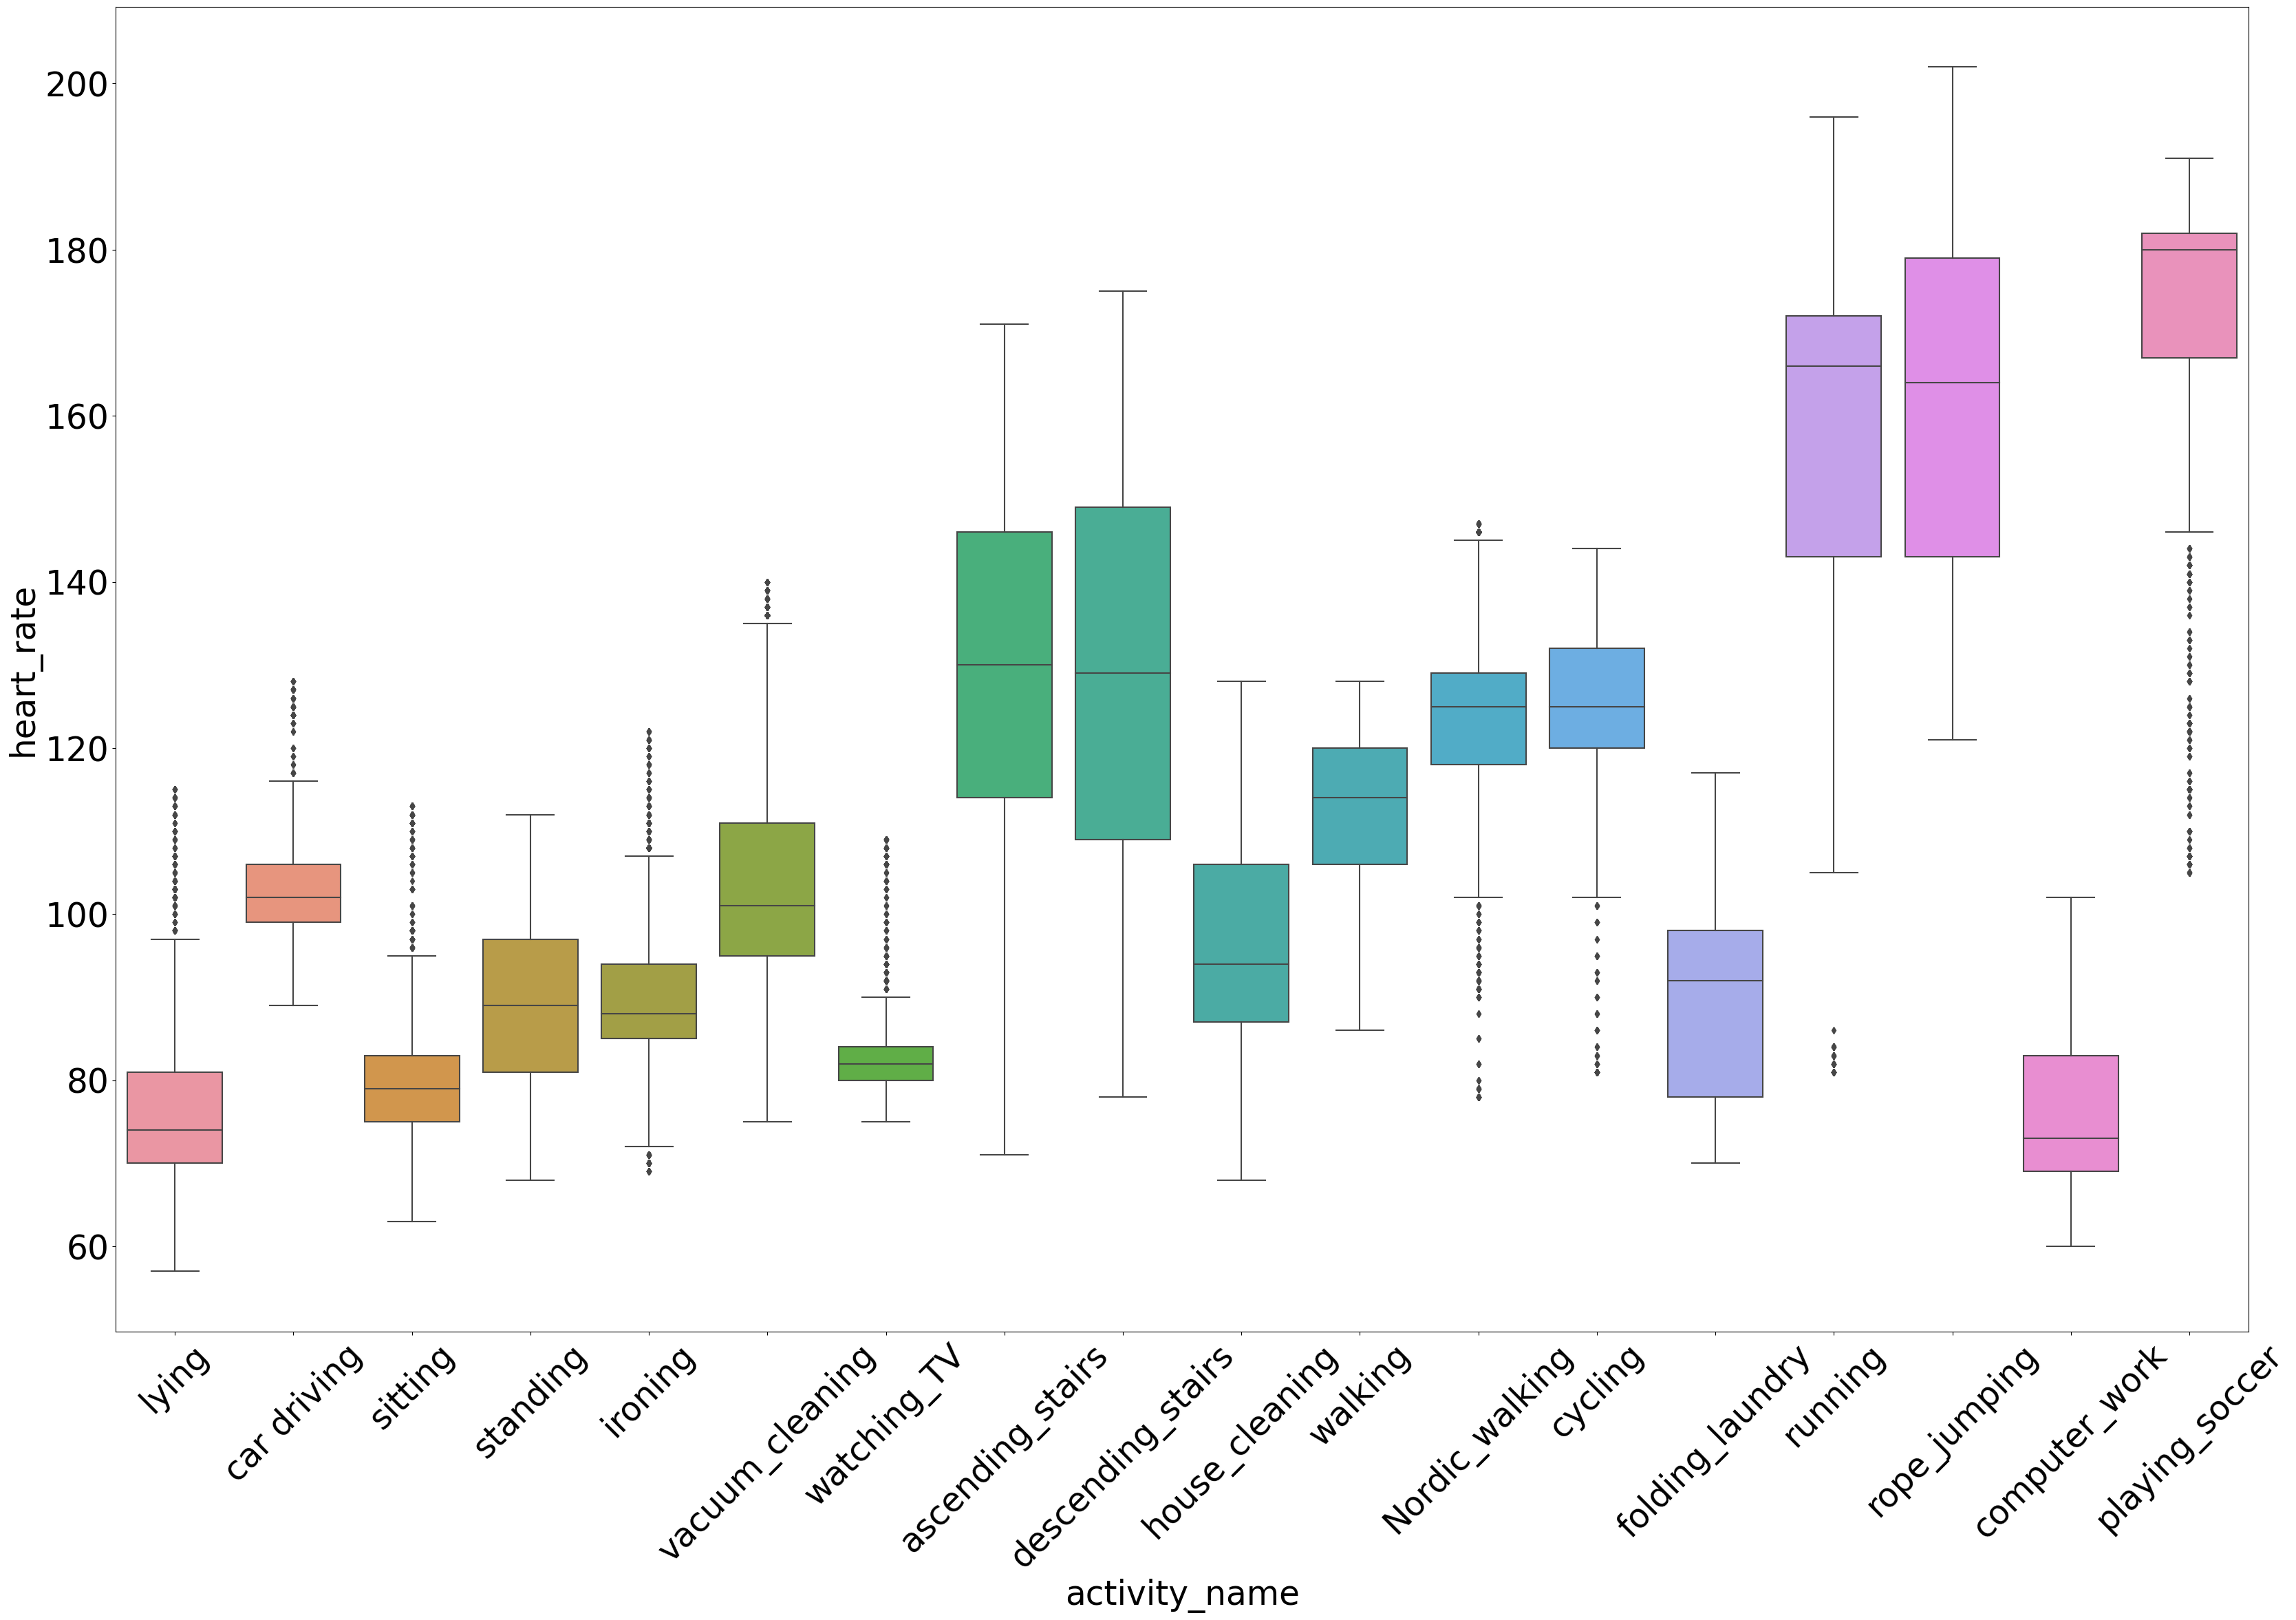

In [6]:
rcParams['figure.figsize'] = 40,25 # Setting the figure dimensions 
rcParams['font.size'] = 35 # Setting the text and number font size
ax=sns.boxplot(x="activity_name",y="heart_rate",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)# Rotating Text
plt.show()

  1. From the boxplot we can notice that activities like running and rope jumping have higher average heart rate than other activities<br>
  2. 'Nordic_walking' and 'running' have a lot of outliers on the lower side<br>
  3.  Activities like 'lying','sitting' and standing have a lot of outliers on the upper side.

* Boxplot of hand temperature grouped by activity

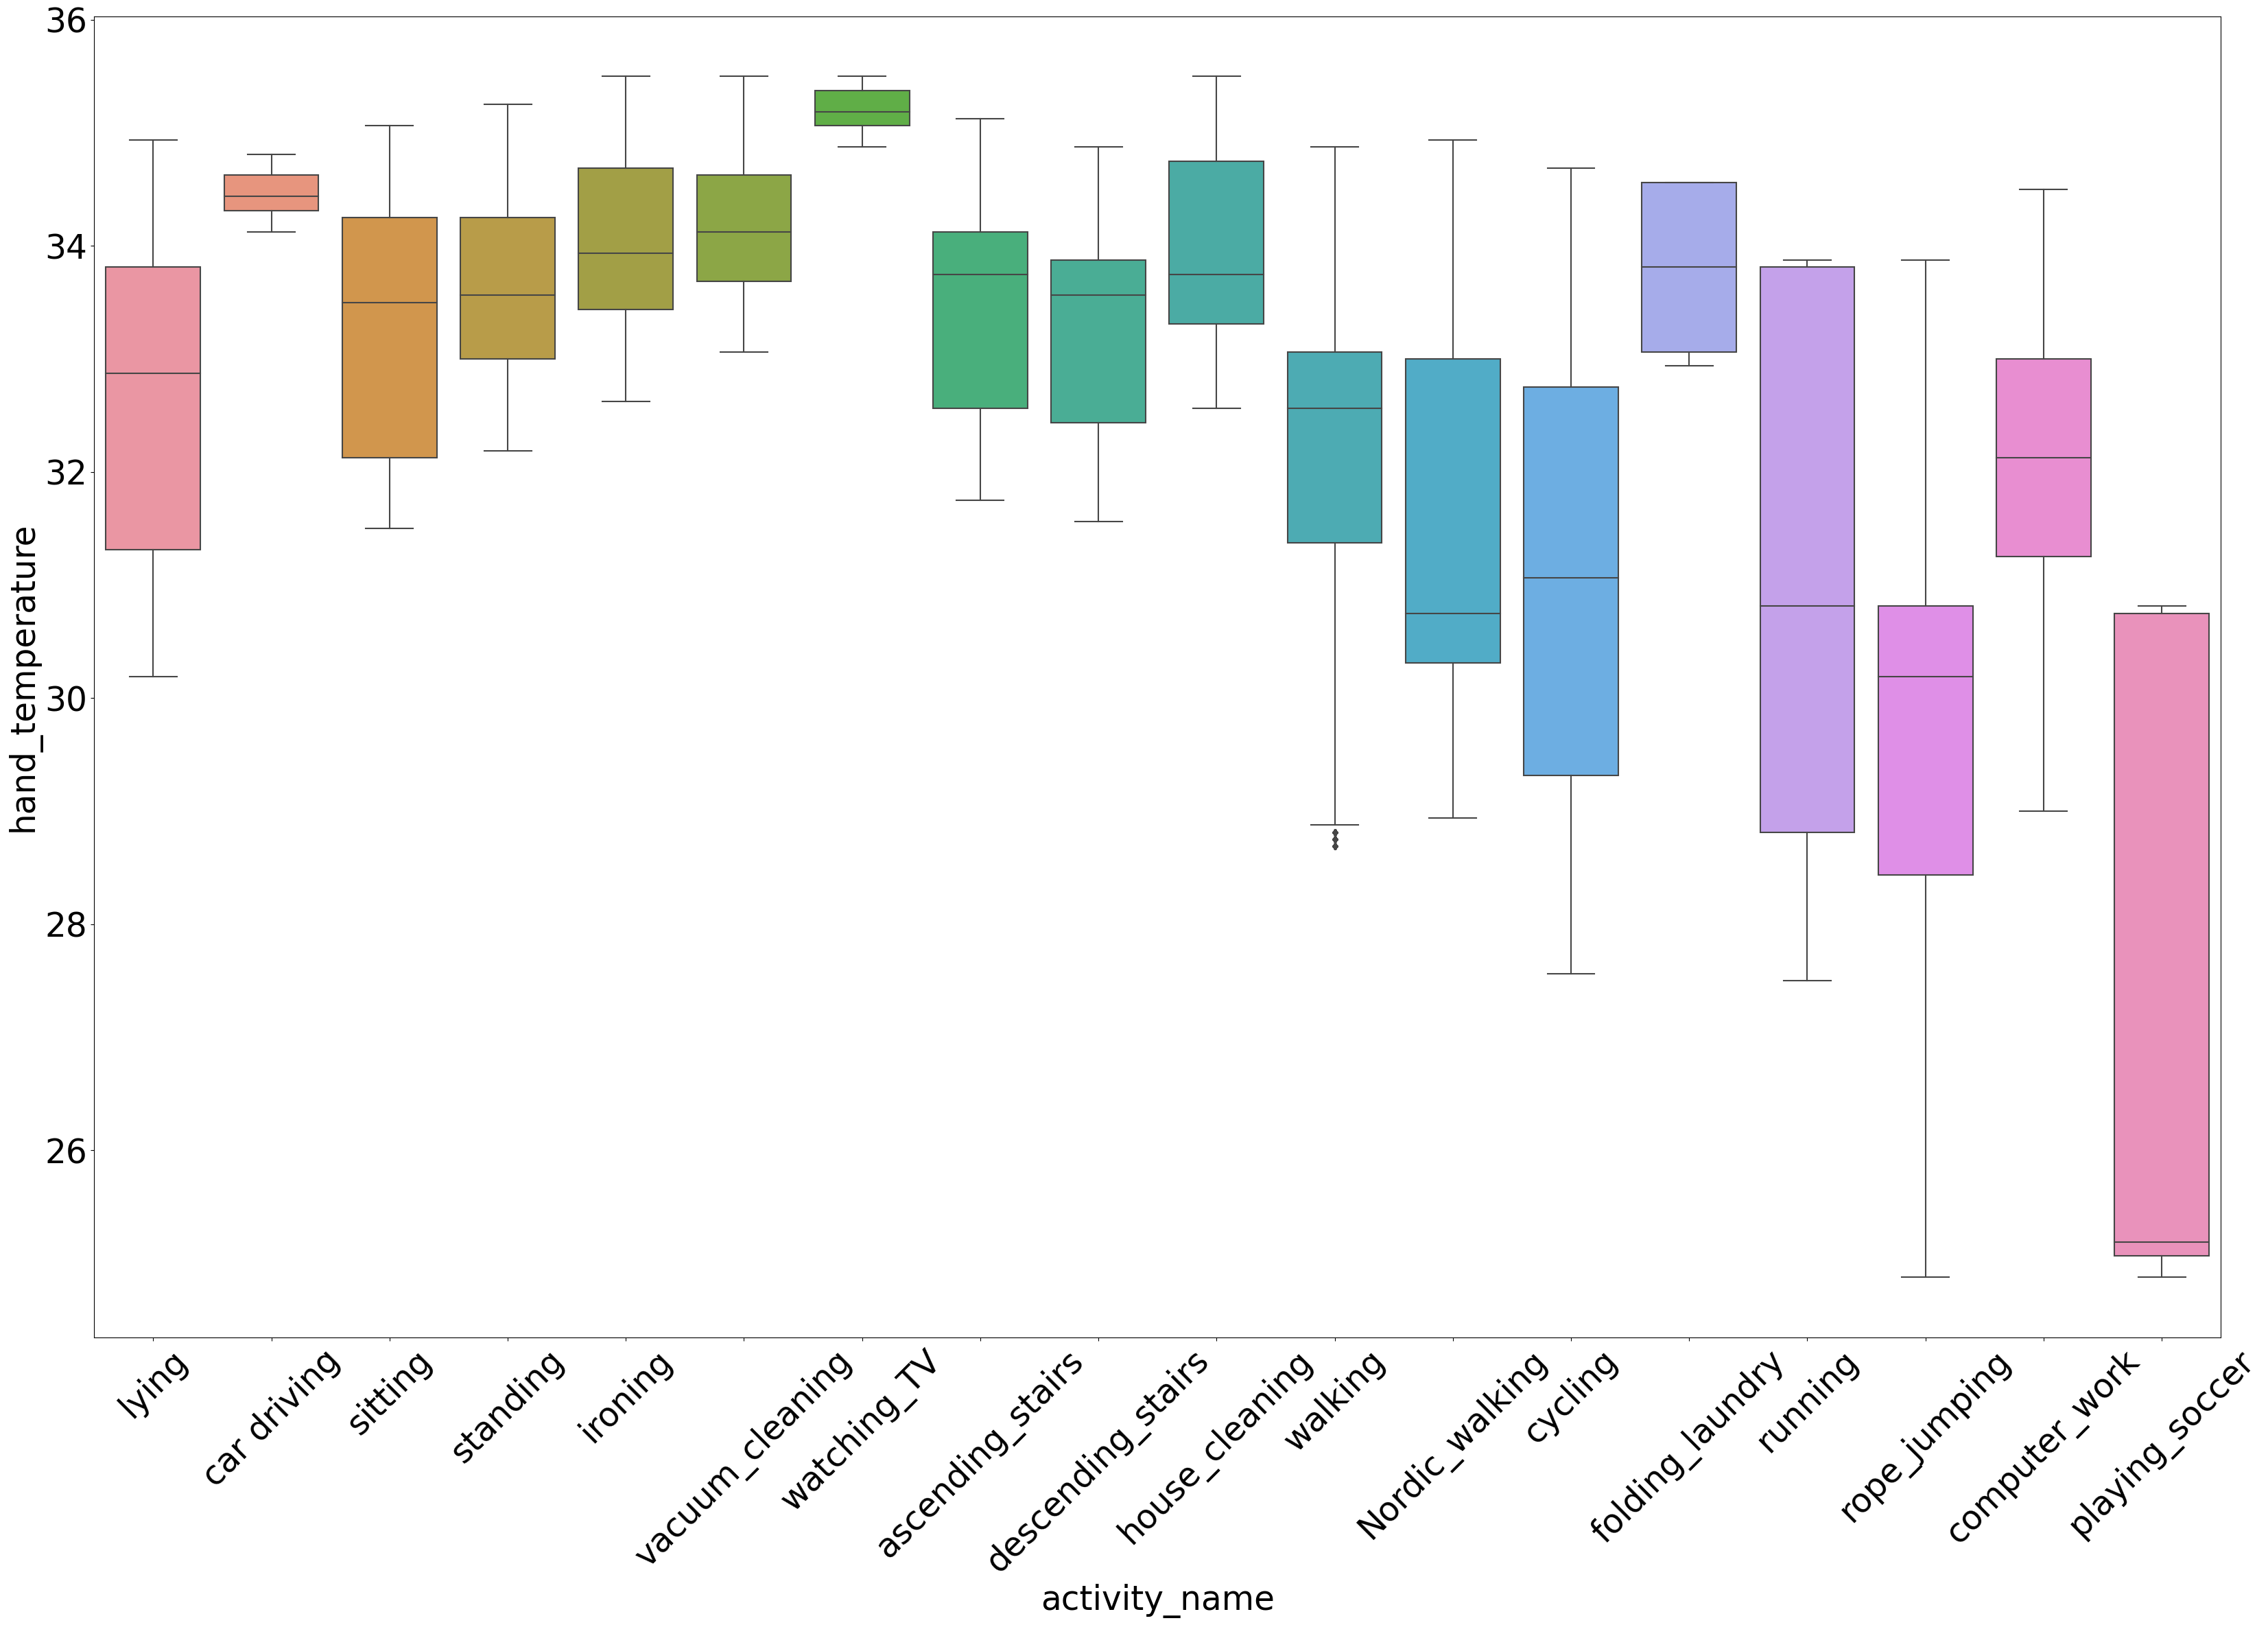

In [7]:
ax=sns.boxplot(x="activity_name",y="hand_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)# Rotating Text
plt.show()

1. "Ironing" and "vacuum_cleaning" may have higher average hand temperatures compared to other activitiies.<br>
2. "Lying" and "standing" have outliers on the upper side while "ascending_stairs" has it on the lower side.

* Boxplot of ankle temperature grouped by activity

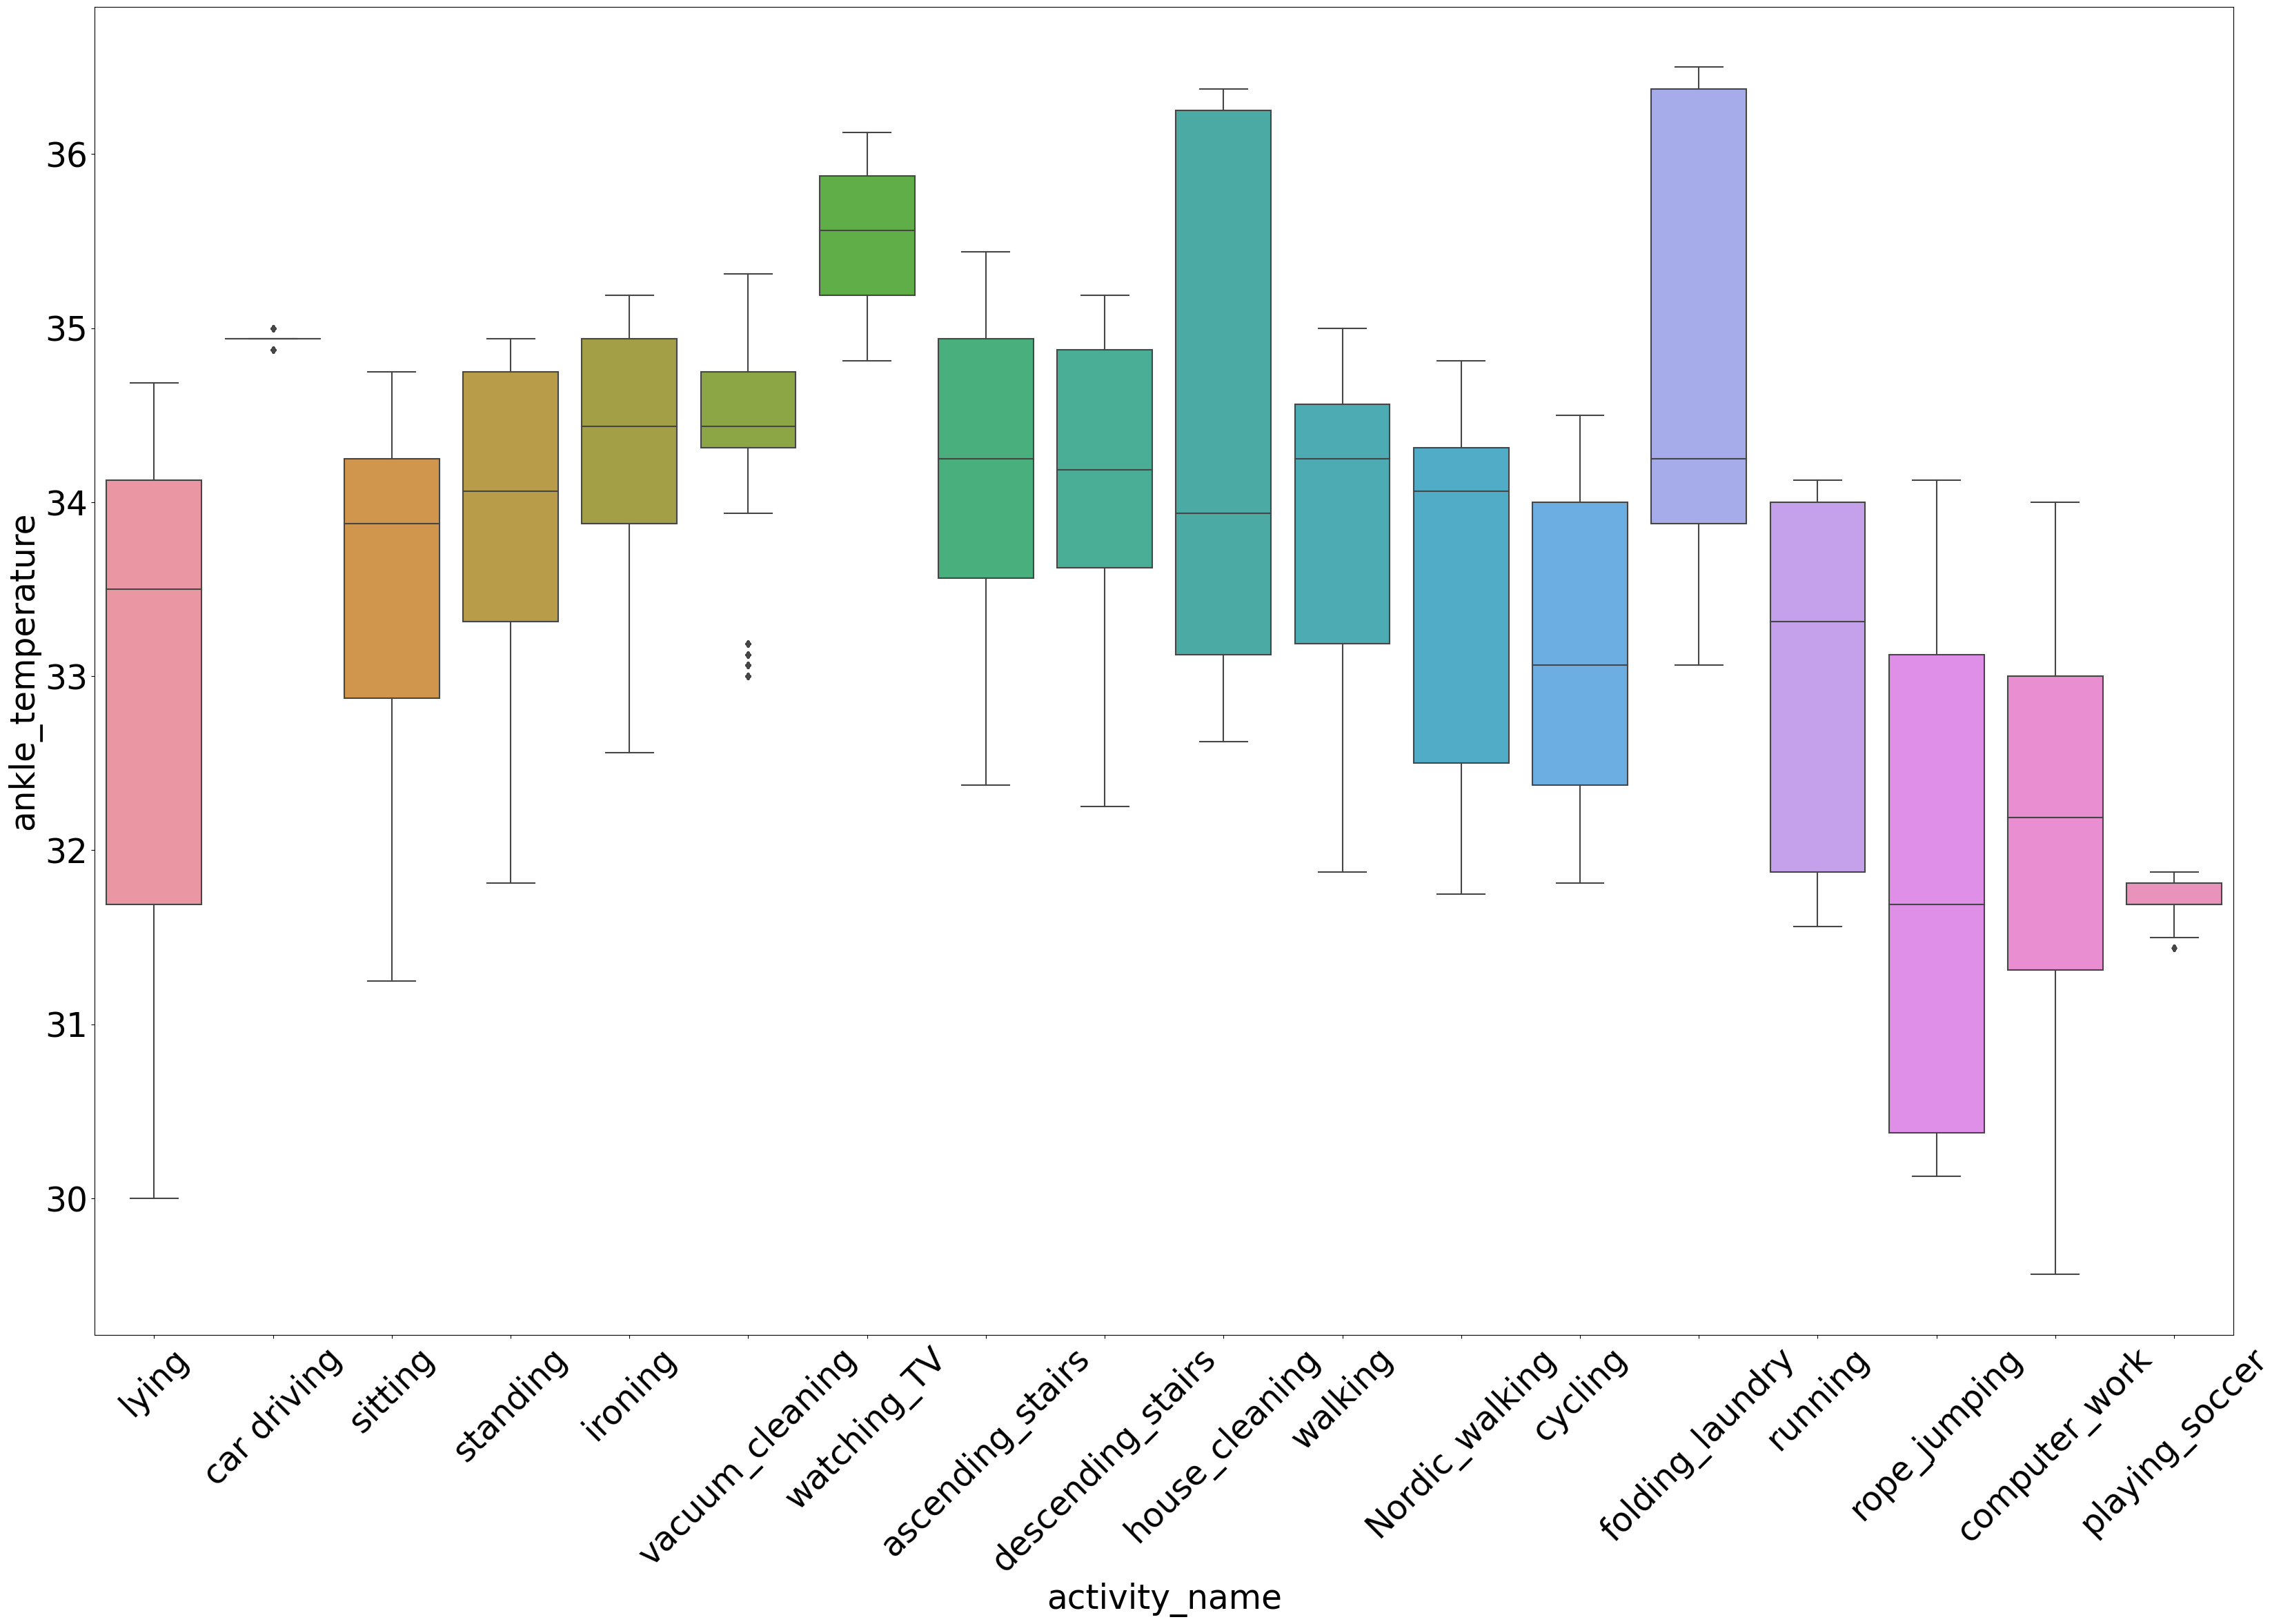

In [8]:
ax=sns.boxplot(x="activity_name",y="ankle_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45) # Rotating Text
plt.show()

1. Interestingly, we see that "ankle_temperature" might be lower on average while lying.<br>
2. Outliers are mostly present in "rope_jumping" and "vacuum_cleaning" on the lower side. 

* Boxplot of chest temperature grouped by activity.

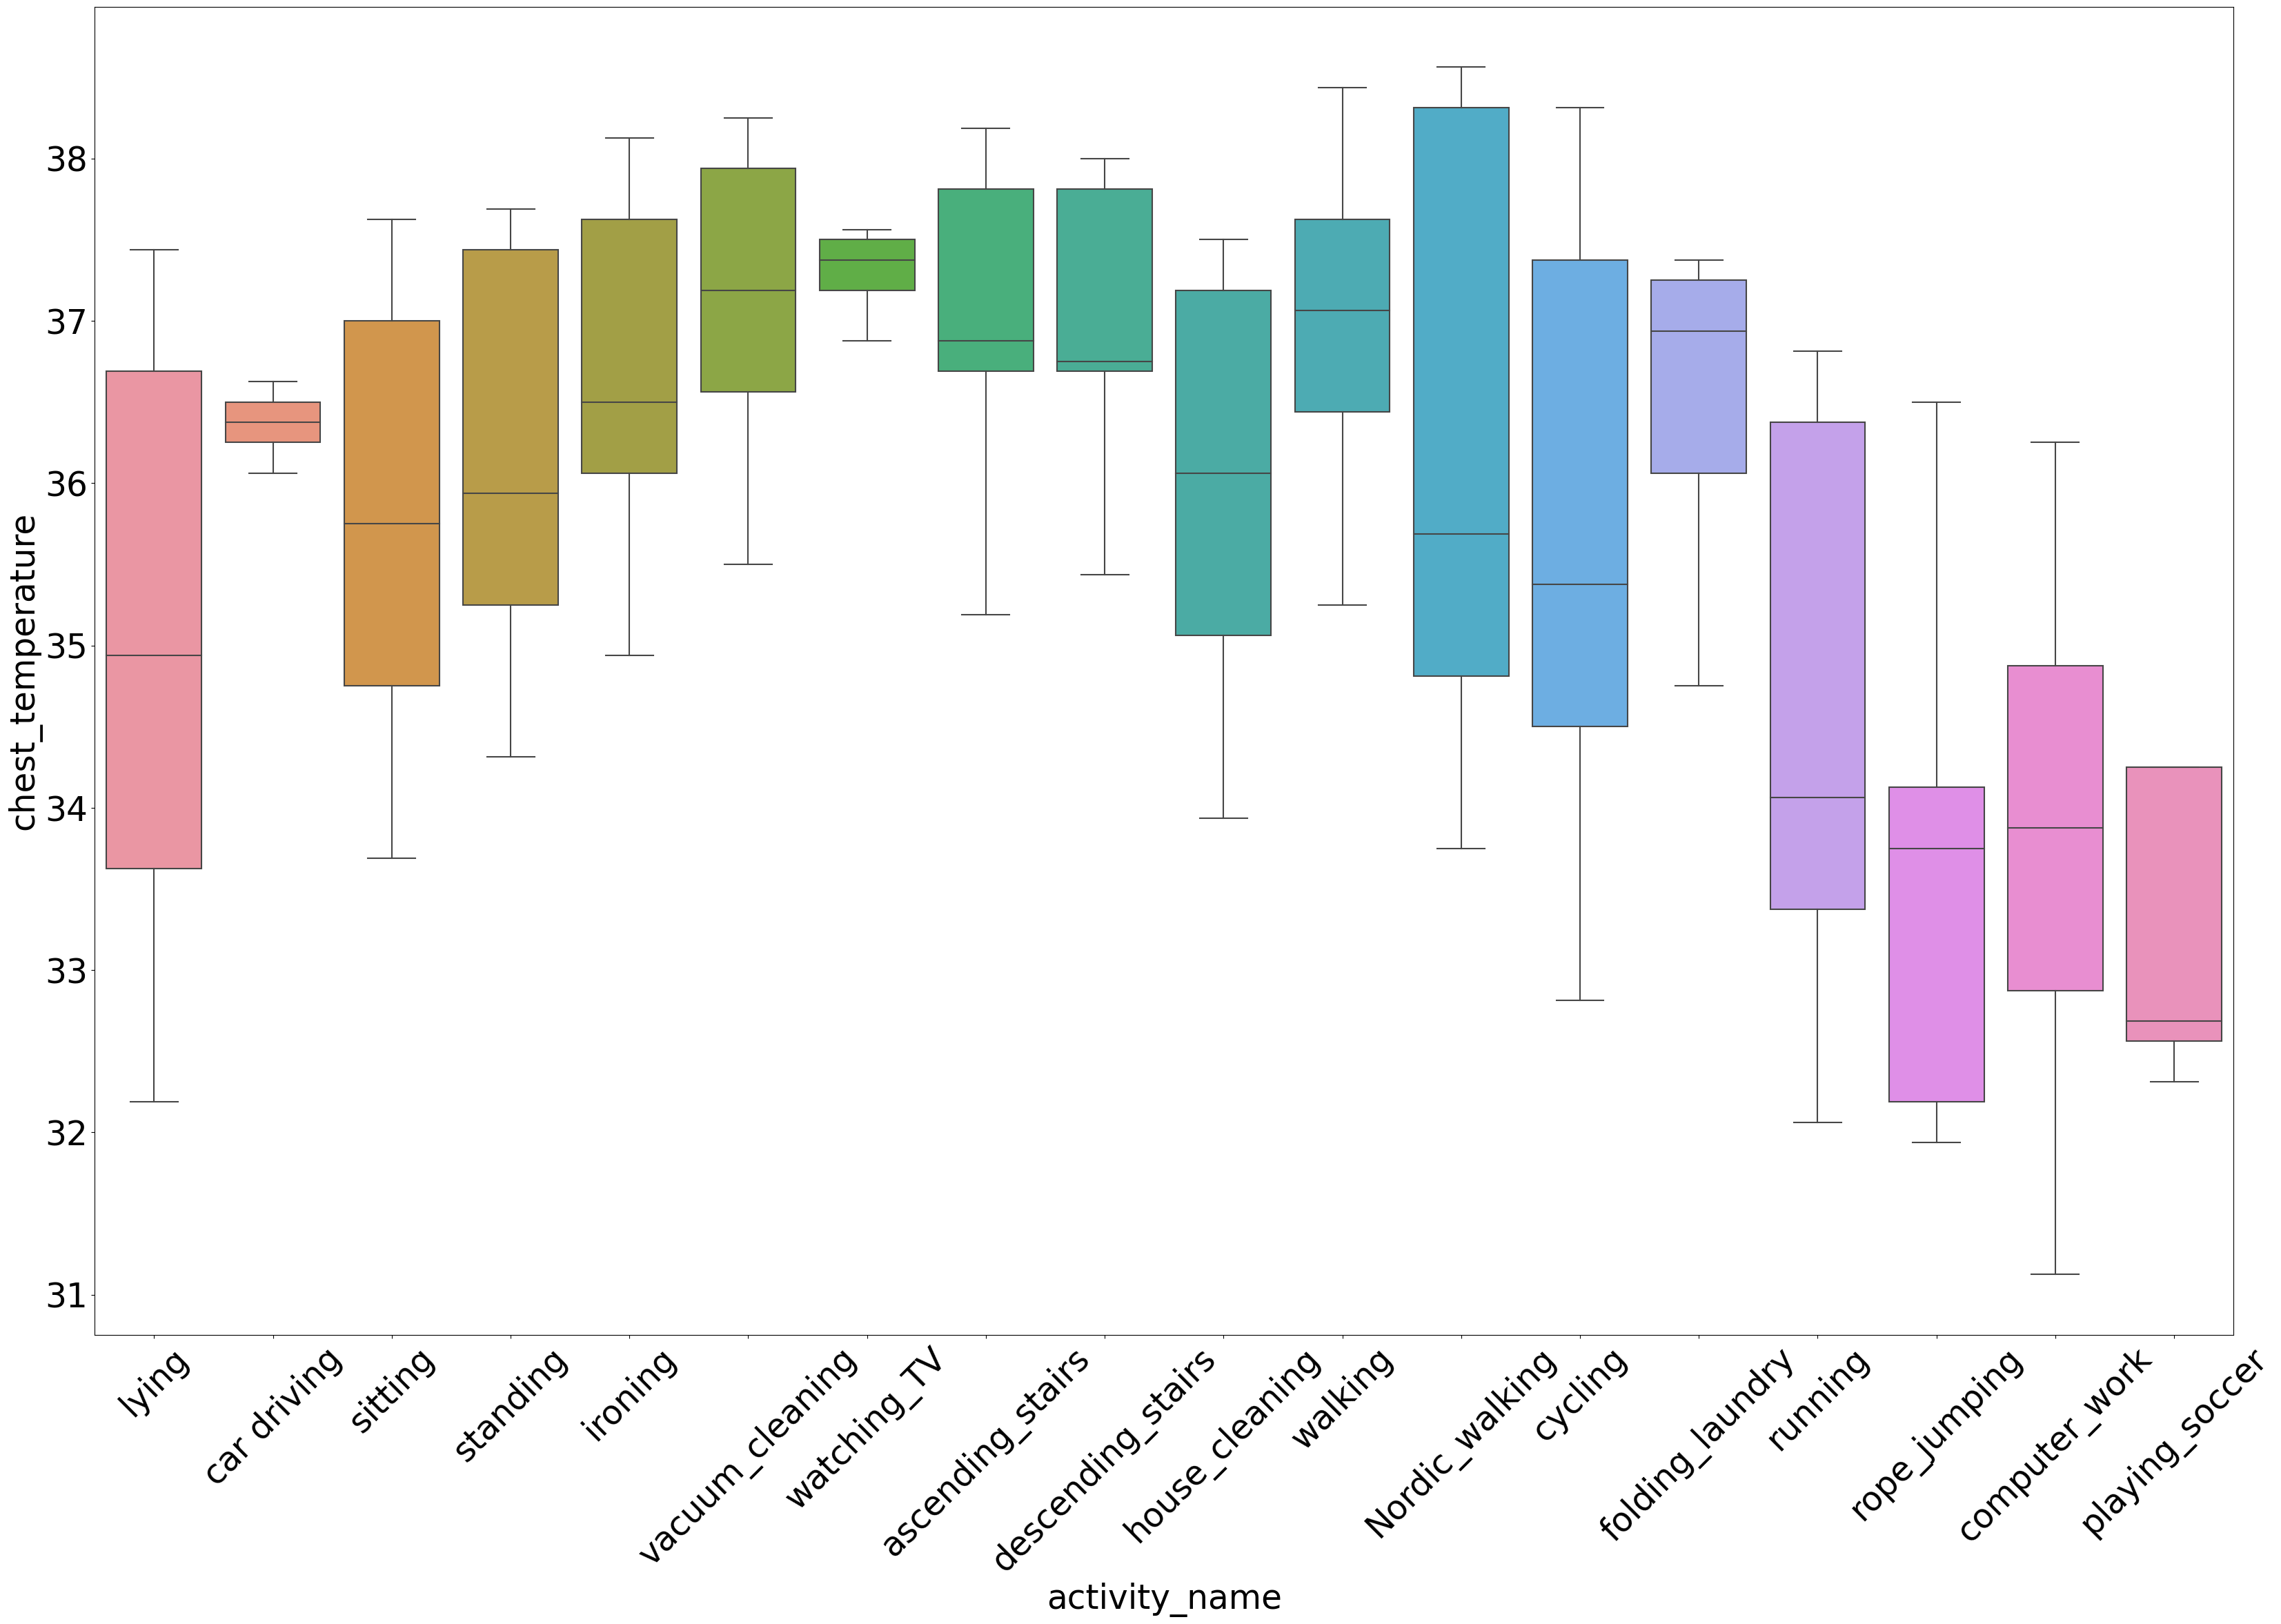

In [9]:
ax=sns.boxplot(x="activity_name",y="chest_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45) # Rotating Text
plt.show()

1. Just like ankle temperature, the mean of chest temperature seems to be lower while lying  <br>
   and even "running" seems to have lower average, although the data is more widely distributed and positively skewed.<br>
2. The outliers are only present in "lying" and they are on the higher side.

* A joint plot trying to investigate possibility of correlation between heart rate <br>
  and chest temperature.

<Figure size 4000x2500 with 0 Axes>

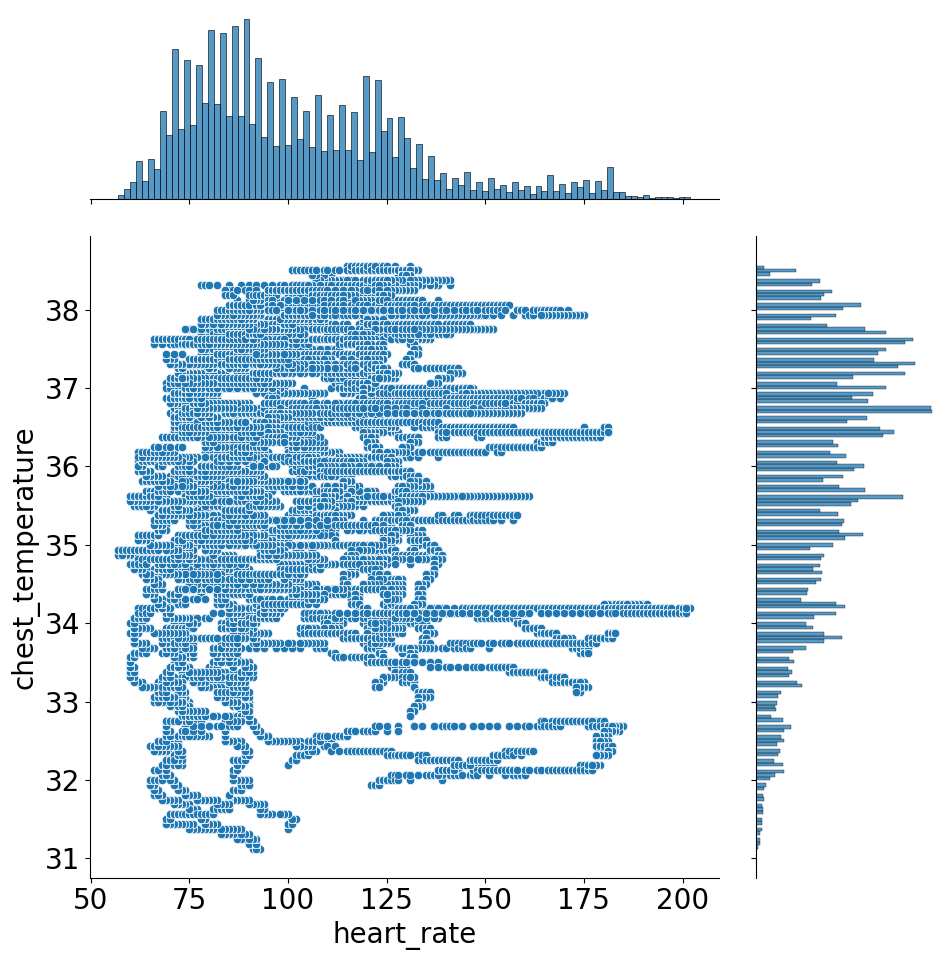

In [10]:
plt.clf()
rcParams['font.size'] = 20 # Setting the text and number font size
g = sns.JointGrid(data=train, x="heart_rate", y="chest_temperature",
                  height=10,ratio=3)
g.plot_joint(sns.scatterplot,palette='colorblind')
g.plot_marginals(sns.histplot)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=45) # Rotating Text
plt.show()

1. From the scatter plot, we see that there does not seem to be a correlation between<br>
   the two variables.<br>
2. The respective histograms indicate that both the features considered have <br>
   a multi-modal distribution.

### Decriptive Statistics<br>
Mean of heart rate and temperatures for each activity

In [11]:
display(train.groupby(by='activity_name')[['heart_rate','chest_temperature','hand_temperature',
    'ankle_temperature']].mean())
discard = ['activity_id','activity','time_stamp','id']# Columns to exclude from descriptive statistics

,heart_rate,chest_temperature,hand_temperature,ankle_temperature
activity_name,,,,
Nordic_walking,123.936004,36.156080,31.538709,33.445371
ascending_stairs,129.278440,37.057398,33.530639,34.170903
car driving,103.179352,36.369624,34.484215,34.936911
computer_work,75.731257,33.843572,32.113359,32.107542
cycling,124.918461,35.725302,31.011366,33.172645
descending_stairs,129.049005,37.021082,33.322129,34.165975
folding_laundry,90.210411,36.459452,33.664159,34.586455
house_cleaning,96.616499,36.033792,34.022582,34.301794
ironing,89.989198,36.670222,34.026188,34.277955


Creating table with only relevant columns

In [12]:
train_trimmed = train[[i for i in train.columns if i not in discard]]

Descriptive info of relevant feature

In [13]:
display(train_trimmed.describe())

,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,...,ankle_3D_acceleration_16_z,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z
count,124083.000000,1.356382e+06,1.356382e+06,1.356382e+06,1.356382e+06,1.356382e+06,1.356382e+06,1.356382e+06,1.356382e+06,1.356382e+06,...,1.357382e+06,1.357382e+06,1.357382e+06,1.357382e+06,1.357382e+06,1.357382e+06,1.357382e+06,1.357382e+06,1.357382e+06,1.357382e+06
mean,102.609133,3.282046e+01,-3.746851e+00,3.636926e+00,3.983126e+00,-3.670749e+00,3.629627e+00,4.170682e+00,-1.605320e-03,3.468351e-02,...,-2.766646e+00,9.010208e+00,-1.839213e-01,-2.343065e+00,8.640038e-03,-2.480970e-02,7.001288e-03,-2.973540e+01,1.320852e+00,1.793444e+01
std,27.334486,1.898107e+00,6.301532e+00,6.565417e+00,4.221681e+00,6.317345e+00,6.353664e+00,4.217225e+00,1.303606e+00,9.453637e-01,...,3.855022e+00,5.645473e+00,6.607152e+00,3.408724e+00,1.048511e+00,5.822103e-01,1.770171e+00,1.932896e+01,2.190831e+01,2.042917e+01
min,57.000000,2.487500e+01,-1.546090e+02,-9.466780e+01,-1.188460e+02,-6.143160e+01,-6.187640e+01,-6.157710e+01,-2.813540e+01,-1.784950e+01,...,-1.595850e+02,-6.105270e+01,-6.190260e+01,-6.247050e+01,-2.907750e+01,-1.309890e+01,-1.444860e+01,-1.726160e+02,-1.404600e+02,-1.489860e+02
25%,82.000000,3.181250e+01,-8.360367e+00,1.047930e+00,1.339010e+00,-8.261717e+00,1.046418e+00,1.557330e+00,-3.021475e-01,-1.642490e-01,...,-3.878910e+00,8.264482e+00,-2.316118e+00,-3.483490e+00,-9.695078e-02,-5.951915e-02,-1.426270e-01,-4.084208e+01,-1.351797e+01,4.471330e+00
50%,96.000000,3.318750e+01,-3.314070e+00,3.626540e+00,3.949960e+00,-3.270515e+00,3.658945e+00,4.205640e+00,-5.754190e-03,4.433965e-03,...,-2.463840e+00,9.499220e+00,-1.397805e-01,-2.044580e+00,5.443820e-03,-3.458360e-03,2.909710e-04,-3.136235e+01,-3.562650e-01,1.982470e+01
75%,120.000000,3.418750e+01,3.292200e-01,6.936128e+00,7.069710e+00,3.986220e-01,6.918057e+00,7.288803e+00,2.628380e-01,2.002155e-01,...,-1.235860e+00,9.825050e+00,1.847818e+00,-7.603840e-01,7.209557e-02,6.266532e-02,5.037450e-02,-1.603112e+01,1.696080e+01,3.438717e+01
max,202.000000,3.550000e+01,7.927800e+01,1.555320e+02,1.577600e+02,6.237240e+01,6.225980e+01,6.192340e+01,2.641580e+01,2.307790e+01,...,1.596970e+02,6.209960e+01,6.205950e+01,6.156360e+01,2.447930e+01,1.316350e+01,1.725420e+01,8.893860e+01,9.424780e+01,1.469000e+02


Correlation table of relevant features

In [14]:
display(train_trimmed.corr()) 

,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,...,ankle_3D_acceleration_16_z,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z
heart_rate,1.000000,-0.370247,-0.393258,0.055827,-0.326994,-0.401309,0.054206,-0.333530,0.011560,0.052161,...,0.007885,0.289477,0.169991,0.006313,0.007188,-0.021091,0.010154,-0.303758,-0.179207,-0.072577
hand_temperature,-0.370247,1.000000,0.107930,-0.000297,0.032575,0.121091,0.003943,0.049548,-0.012654,-0.017423,...,-0.084960,-0.149079,-0.078347,-0.088727,-0.007741,0.019720,0.001575,0.128146,0.150081,0.149565
hand_3D_acceleration_16_x,-0.393258,0.107930,1.000000,-0.047705,0.284511,0.983195,-0.043375,0.290575,0.018222,-0.091044,...,-0.024825,-0.302146,-0.080691,-0.028542,0.034569,-0.047907,0.084158,0.150718,0.140302,0.030554
hand_3D_acceleration_16_y,0.055827,-0.000297,-0.047705,1.000000,-0.120924,-0.035566,0.954816,-0.122458,0.158904,-0.018140,...,-0.041149,-0.007744,0.077979,-0.045829,0.003731,-0.027350,-0.025416,0.023289,0.016736,0.072203
hand_3D_acceleration_16_z,-0.326994,0.032575,0.284511,-0.120924,1.000000,0.282055,-0.122207,0.972191,-0.033238,-0.000499,...,0.048656,-0.115601,-0.024592,0.056370,0.007153,-0.011895,0.020649,0.082511,-0.005420,-0.004221
hand_3D_acceleration_6_x,-0.401309,0.121091,0.983195,-0.035566,0.282055,1.000000,-0.039614,0.287165,0.020022,-0.070927,...,-0.025908,-0.299138,-0.080347,-0.029509,0.034519,-0.047546,0.073966,0.152350,0.144824,0.033663
hand_3D_acceleration_6_y,0.054206,0.003943,-0.043375,0.954816,-0.122207,-0.039614,1.000000,-0.115140,0.106493,-0.023998,...,-0.041142,-0.012561,0.079323,-0.046149,0.005373,-0.026553,-0.004274,0.022509,0.017992,0.074911
hand_3D_acceleration_6_z,-0.333530,0.049548,0.290575,-0.122458,0.972191,0.287165,-0.115140,1.000000,-0.022839,-0.027091,...,0.047624,-0.121567,-0.025616,0.054411,0.006544,-0.012472,0.021406,0.085180,-0.001117,-0.001622
hand_3D_gyroscope_x,0.011560,-0.012654,0.018222,0.158904,-0.033238,0.020022,0.106493,-0.022839,1.000000,-0.232763,...,-0.011698,0.017163,0.004872,-0.015271,0.012559,-0.027782,0.129502,0.010236,-0.049110,-0.001326
hand_3D_gyroscope_y,0.052161,-0.017423,-0.091044,-0.018140,-0.000499,-0.070927,-0.023998,-0.027091,-0.232763,1.000000,...,-0.027616,0.049645,0.012329,-0.030528,0.044048,0.085075,-0.042192,-0.010631,0.000169,-0.016341


## Hypothesis Testing  

Based on the exploratory data analysis carried out, the following hypotheses are tested on  <br>
the test set:<br>
- Hand temperature is higher during 'ironing' and 'vacuum_cleaning' compared<br>
  to other activities.<br>
- Ankle temperature is lower than other activities while lying.<br>
- Chest temperature is lower while lying compared to other activities. 

Based on the EDA  we performed, it does not seem that the data is normally distributed. It is <br>
for this reason that Wilcoxon rank sum test was used to test the above hypothesis instead of the usual t-test which assumes that the samples follow a normal distribution.<br>
We test the above hypothesis using the confidence level of 5%.

$H_0$(Null) : The hand temperature while ironing and while doing other activities are not significantly  different.<br>
$H_1$(Alternate) : The hand temperature while ironing is likely to be higher compared to other activities.

In [15]:
test1 = test[test.activity_name=='ironing'].hand_temperature.dropna()# Hand temperature while ironing
test2 = test[test.activity_name!='ironing'].hand_temperature.dropna()# hand temperature while not ironing.Nan values dropped to get the actual size of samples.
print(ranksums(test1,test2,alternative='greater'))

RanksumsResult(statistic=244.21226325853038, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 

$H_0$(Null) : The hand temperature while 'vacuum_cleaning' and while doing other activities are not significantly  different.<br>
$H_1$(Alternate) : The hand temperature while 'vacuum_cleaning' is likely to be higher compared to other activities.

In [16]:
test1 = test[test.activity_name=='vacuum_cleaning'].hand_temperature.dropna()
test2 = test[test.activity_name!='vacuum_cleaning'].hand_temperature.dropna()
print(ranksums(test1,test2,alternative='greater'))

RanksumsResult(statistic=249.30183579118255, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 

$H_0$(Null) : The ankle temperature while lying and while doing other activities are not significantly  different.<br>
$H_1$(Alternate) : The ankle temperature while lying is likely to be lower compared to other activities.

In [17]:
test1 = test[test.activity_name=='lying'].ankle_temperature.dropna()
test2 = test[test.activity_name!='lying'].ankle_temperature.dropna()
print(ranksums(test1,test2,alternative='less'))

RanksumsResult(statistic=-141.82986233034507, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 

$H_0$(Null) : The chest temperature while lying and while doing other activities are not significantly  different.<br>
$H_1$(Alternate) : The chest temperature while lying is likely to be lower compared to other activities.

In [18]:
test1 = test[test.activity_name=='lying'].chest_temperature.dropna()
test2 = test[test.activity_name!='lying'].chest_temperature.dropna()
print(ranksums(test1,test2,alternative='less'))

RanksumsResult(statistic=-165.6843463224599, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 